# Regression on biodiversity index

We are going to test different models on our dataset, trying to get a better results using a grid search and the testing the models on a dataset of a different region.

For each model we're going to use a RandomizedSearchCV to narrow our parameters research and the the GridSearchCV to find the best one.

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import sys
import torch

import matplotlib.pyplot  as plt 
from itertools import combinations 
from typing import Dict, Any
from scipy.stats import uniform, randint
from sklearn.decomposition import PCA

from sklearn import preprocessing

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

module_this = os.path.abspath(os.path.join(os.getcwd()))
modules = [ module_this]

for module in modules:
    if module not in sys.path:
        sys.path.append(module)

import utils as ut

## Load Datasets

In [24]:
folder = "../Dataset/images/"
regression_label = 'habitat_richness'
test_size = 0.2
#swi_labels = ['SWI1km-SWI-002', 'SWI1km-SWI-100', 'SWI1km-SWI-040', 'SWI1km-SWI-005', 
#              'SWI1km-SWI-010', 'SWI1km-SWI-060', 'SWI1km-SWI-015', 'SWI1km-SWI-020']




df_train = pd.read_csv(folder + "/italy_train.csv", index_col=['longitude', 'latitude'])
df_val = pd.read_csv(folder + "/italy_validation.csv", index_col=['longitude', 'latitude'])
df_test = pd.read_csv(folder + "/italy_test.csv", index_col=['longitude', 'latitude'])
df_train.append(df_val)
X_train = df_train.drop(columns=[regression_label]).values
y_train = df_train[regression_label].values
X_test = df_test.drop(columns=[regression_label]).values
y_test = df_test[regression_label].values


data = {'name': 'italy',  'X_train': X_train, 'X_test': X_test, 
            'y_train': y_train, 'y_test': y_test}

cv = KFold(n_splits=4, shuffle=True, random_state = 42)
scaler = preprocessing.MinMaxScaler()


## Grid search

In [49]:
def grid_search_train_test(data, grid_search):
    print(data['name'])
    grid_search.fit(data['X_train'], np.log(data['y_train']))
    print('\tcross validation best score: \t',  "{:.3f}".format(grid_search.best_score_))
    print('\tbest params: ', grid_search.best_params_)
    best_model = grid_search.best_estimator_
    test_score = best_model.score(data['X_test'], np.log(data['y_test']))
    train_score = best_model.score(data['X_train'], np.log(data['y_train']))
    print("\tbest model train score: \t\t", "{:.3f}".format(train_score))
    print("\tbest model test score: \t\t", "{:.3f}".format(test_score))
    print('--------------------------------------------')
    return grid_search.best_estimator_

def model_train_test(data, model, cv):
    print(data['name'])
    val_score = cross_val_score(model, data['X_train'], np.log(data['y_train']), cv=cv, n_jobs=-1, verbose=0)
    print('all scores:', val_score)
    print("\t validation score: \t", "{:.3f}".format(val_score.mean()), " +/- ", "{:.3f}".format(val_score.std()*2))
    model.fit(data['X_train'], data['y_train'])
    test_score = model.score(data['X_test'], np.log(data['y_test']))
    print("\tbest model test score: \t\t", "{:.3f}".format(test_score))
    print('--------------------------------------------')
    return model

def apply_trained_model(datas, model):
    for data in datas:
        test_score = model.score(data['X_test'], np.log(data['y_test']))
        print(data['name'], "\tbest all data model score: \t\t", "{:.3f}".format(test_score))
        print('--------------------------------------------')

### Decision Tree

In [47]:
max_features = ['auto', 'sqrt']
criterion = ['mse', 'friedman_mse']
max_depth = [4, 8, 16, 32, None]

grid_params = {'dtr__max_features': max_features,
              'dtr__criterion': criterion,
              'dtr__max_depth': max_depth}
grid_params

{'dtr__max_features': ['auto', 'sqrt'],
 'dtr__criterion': ['mse', 'friedman_mse'],
 'dtr__max_depth': [4, 8, 16, 32, None]}

In [48]:
print(" ------- Regional datas ------- \n")
dtr = DecisionTreeRegressor()
model = Pipeline([('scaler', scaler), ('dtr', dtr)])

grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)
grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

italy
	cross validation best score: 	 0.718
	best params:  {'dtr__criterion': 'mse', 'dtr__max_depth': 8, 'dtr__max_features': 'auto'}
	best model test score: 		 0.820
	best model test score: 		 0.729
--------------------------------------------


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('dtr',
                 DecisionTreeRegressor(max_depth=8, max_features='auto'))])

### Random Forest Regressor

In [28]:
n_estimators = [50, 100, 200]
max_features = ['auto', 'sqrt']
max_depth = [20, 50, None]
min_samples_split = [2, 5]
min_samples_leaf = [1, 4]
bootstrap = [False, True]

grid_params = {'rfr__n_estimators': n_estimators,
               'rfr__max_features': max_features,
               'rfr__max_depth': max_depth,
               'rfr__min_samples_split': min_samples_split,
               'rfr__min_samples_leaf': min_samples_leaf,
               'rfr__bootstrap': bootstrap
              }

In [29]:
print(" ------- Regional datas ------- \n")
rfr = RandomForestRegressor()
model = Pipeline([('scaler', scaler), ('rfr', rfr)])

grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)
grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

italy
	cross validation best score: 	 0.832
	best params:  {'rfr__bootstrap': False, 'rfr__max_depth': 20, 'rfr__max_features': 'sqrt', 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 200}
	best model test score: 		 0.850
--------------------------------------------


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfr',
                 RandomForestRegressor(bootstrap=False, max_depth=20,
                                       max_features='sqrt',
                                       n_estimators=200))])

### SVM

In [30]:
C = [0.1, 1, 10]
gamma = ['auto', 0.1, 0.01]
kernel = ['linear', 'rbf']

grid_params = {'svr__C': C,  
              'svr__gamma': gamma, 
              'svr__kernel': kernel}  
grid_params

{'svr__C': [0.1, 1, 10],
 'svr__gamma': ['auto', 0.1, 0.01],
 'svr__kernel': ['linear', 'rbf']}

In [31]:
print(" ------- Regional datas ------- \n")
svr = SVR()
model = Pipeline([('scaler', scaler), ('svr', svr)])

grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)

grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

italy
	cross validation best score: 	 0.718
	best params:  {'svr__C': 10, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
	best model test score: 		 0.714
--------------------------------------------


Pipeline(steps=[('scaler', MinMaxScaler()), ('svr', SVR(C=10, gamma=0.1))])

## Neural Network

In [32]:
max_iter = [1000]
alpha = [0.001, 0.0001, 0.00001]
solver = ['lbfgs']
hidden_layer_sizes = [(100, 50), (46, 100, 46), (46, 100, 46, 20)]

grid_params = {'nn__solver': solver, 
               'nn__max_iter': max_iter,
               'nn__alpha': alpha, 
               'nn__hidden_layer_sizes': hidden_layer_sizes
              }
grid_params

{'nn__solver': ['lbfgs'],
 'nn__max_iter': [1000],
 'nn__alpha': [0.001, 0.0001, 1e-05],
 'nn__hidden_layer_sizes': [(100, 50), (46, 100, 46), (46, 100, 46, 20)]}

In [33]:
print(" ------- Regional datas ------- \n")
nn = MLPRegressor()
model = Pipeline([('scaler', scaler), ('nn', nn)])
best params =  {'nn__alpha': [0.001], 'nn__hidden_layer_sizes': [(46, 100, 46, 20)], 'nn__max_iter': [1000, 2000], 'nn__solver': ['lbfgs']}
grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)
grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

italy
	cross validation best score: 	 0.774
	best params:  {'nn__alpha': 0.001, 'nn__hidden_layer_sizes': (46, 100, 46, 20), 'nn__max_iter': 1000, 'nn__solver': 'lbfgs'}
	best model test score: 		 0.779
--------------------------------------------


C:\Users\minoc\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('nn',
                 MLPRegressor(alpha=0.001, hidden_layer_sizes=(46, 100, 46, 20),
                              max_iter=1000, solver='lbfgs'))])

### Plot results

In [32]:
score = np.array([0.73, 0.85, 0.714, 0.799, 0.784])
regional_label = ['italy']
model_label = ['a', 'decision tree', 'random forest', 'SVM', 'neural network', 'Images + Feature NN']

In [33]:
def plot_score(scores, x_label, bar_label, y_label):
    N = len(x_label)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.15 
    fig = plt.figure(figsize=((10, 5)))

    ax = fig.add_subplot(111)

    axs = []

    for i, score in enumerate(scores):
        axs += [ax.bar(ind+width*i, score, width)]

    ax.set_ylabel(y_label)
    ax.legend((x for x in axs), (bar_label))
    ax.set_xticks(ind+width*2.5)
    ax.set_xticklabels( (x_label) )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h + np.sign(h)*0.05, "{:.3f}".format(h),
                    ha='center', va='bottom')
    y_lim1 = np.min(scores) -0.1 if np.min(scores) -0.1 < 0 else 0
    y_lim2 = np.max(scores) + 0.1 if np.max(scores) + 0.1 < 1.1 else 1.1
    plt.ylim(y_lim1, y_lim2)
    for x in axs:
        autolabel(x)

<ipython-input-34-3019b595db66>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_label)


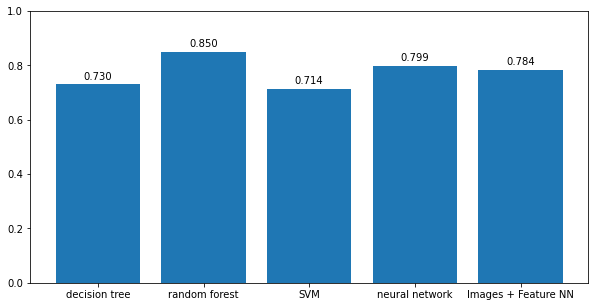

In [34]:
x = np.arange(len(score))

fig, ax = plt.subplots(figsize=(10,5))
#ax.yaxis.set_major_formatter(formatter)
x = ax.bar(x, score)
ax.set_xticklabels(model_label)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h + np.sign(h)*0.01, "{:.3f}".format(h),
                ha='center', va='bottom')
autolabel(x)
plt.ylim(0, 1)
plt.show()

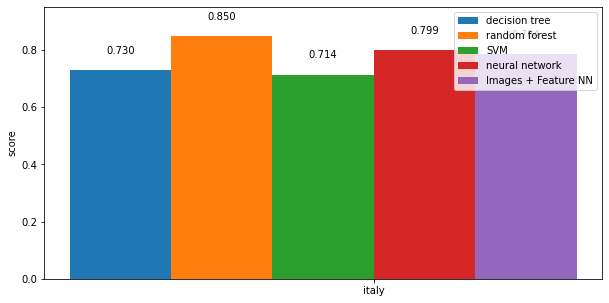

In [4]:
plot_score(score, regional_label, model_label, 'score')